# Exploring the edge effect in the data

For this exploration, we need the full representation of the connectome, so we load it in "conntility" format.
This package can be installed using:
 > pip install Connectome-Utilities
 
The other packages are standard

In [24]:
import pandas
import numpy
import conntility

fn_mat = "microns_mm3_connectome.h5"
name_dset_f = "full"
name_dset_c = "condensed"

M = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_f)
#C = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_c)

## Edge effect
Edge effect refers to the issue that near the borders of the reconstructed volume a connectome becomes "incomplete" due to several reasons:
First, in this particular connectome, we only consider the _internal_ connectivity, i.e. the connections between neurons with somata inside the volume. Overall, many long-range connections will be missing. But near the border of the volume, also a significant fraction of short-range connectivity will be coming from neurons outside the volume and be missing*.
Second, in the case of an EM reconstruction, if a dendrite leaves the reconstructed volume, it may not be further traced and be missing from the data. This can lead to connections between neurons inside the volume being missed, if the location of the synapse is outside the volume. For many purposes, this kind of error is more severe, because it affects parts of the data that are explicitly represented: E.g. the view of the connectome as an adjacency matrix explicitly claims that connections between neurons inside the volume are present or absent and this type of error can lead to false negatives.

Therefore, we might want to know which parts of the volume are affected by this.

(*Note that the original microns dataset also provides extrinsic synapses, but for the data used here it has not been loaded)

### Preparation
We want to visualize mean statistics of neurons / synapses in a "top-down" view.
Therefore, we bin all neurons and synapses into 2d bins based on their x and z coordinates (y is mostly vertical). Then we can calculate means or sums over bins easily.

In [72]:
nbins= 51
extents = {}
for col in ["x_nm", "z_nm"]:
    bins = numpy.linspace(M.edges[col].min(), M.edges[col].max() + 1, nbins)
    extents[col] = [bins[0] / 1000, bins[-1] / 1000]
    M.add_edge_property(col + "_binned_{0}".format(nbins),
                        numpy.digitize(M.edges[col], bins=bins))
    M.add_vertex_property(col + "_binned_{0}".format(nbins),
                        numpy.digitize(M.vertices[col], bins=bins))

### Top-down view of synapse density
We take a look at the number of synapses in each spatial 2d bin.
Without edge effect this would be largely constant, with some biological variability.

(593.68, 1114.601)

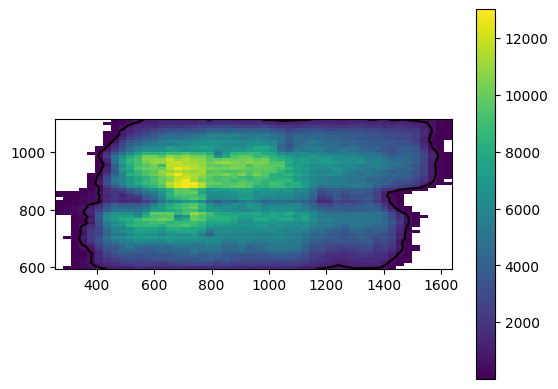

In [113]:
from matplotlib import pyplot as plt

I = M.edges.groupby(["x_nm_binned_51",
                     "z_nm_binned_51"])["id"].count().unstack("x_nm_binned_51")

plt.colorbar(plt.imshow(I.values,
            extent=extents["x_nm"] + extents["z_nm"][::-1]))
plt.contour(I.values, cmap="hot", levels=[1000.],
           extent=extents["x_nm"] + extents["z_nm"])
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])

Instead, we see that it drops low near the borders of the volume. This is due to the _first_ type of edge effect outlined above.
But here, we want to explore the second type. 

A neuron is affected by the second type of edge effect if its dendrite leaves the reconstructed volume. Ideally, we would inspect the dendrite meshes that are provided by microns. But that would be complicated and take very long to load. Here, we use a very simple heuristic: If a dendrite leaves the volume it must first cross the voxels near the border of the volume. In that case, it is likely to form synapses in those voxels. Therefore, we simply count the fraction of afferent synapses a neuron forms in the border region, and if it exceeds a threshold it is in danger of being affected.

Again, looking at the meshes is the proper thing to do, but this simple approach can be used to get a first overview.

#### Define border voxels
We utilize the fact that near the border the synapse density (above) is low. We define a region as border if the synapse count of the associated 2d bin is < 1000. Additionally, we define 3 bins at the top and bottom of the z-stack as border.

Then we can lookup from the resulting table for all synapses if they are inside the border and add that as a property to them. 

In [98]:
edge_idxx = pandas.MultiIndex.from_frame(M.edges[["z_nm_binned_51", "x_nm_binned_51"]])
is_outer_bin = I.stack().rename("count").reset_index()
is_outer_bin["outer"] = ((is_outer_bin["count"] < 1000) |
                         (is_outer_bin["z_nm_binned_51"] <= 3) | 
                         (is_outer_bin["z_nm_binned_51"] >= (nbins - 3)))
is_outer_bin = is_outer_bin.set_index(["z_nm_binned_51", "x_nm_binned_51"])["outer"]

in_outer_bin = is_outer_bin[edge_idxx]
M.add_edge_property("syn_in_outer_bin", in_outer_bin.values)

We then generate a compressed view: Each set of synapses between a pair of neurons is compressed to a single edge. We make sure that the edge is associated with a property that is the number of synapses between them that are inside the border.

In [100]:
C = M.compress({
    "outer_bin_count": ("syn_in_outer_bin", "sum")
})

Now we calculate the sum of afferent border synapses of each neuron. To that end, we simply calculate the sum over the .matrix view of the connectome. We use .default to set the edge property that is returned inside the matrix.

The fraction of border synapses per neuron can then be easily calculated by comparing the result to the total indegree.

In [106]:
outer_per_neuron = numpy.array(C.default("outer_bin_count").matrix.sum(axis=0))[0]
C.add_vertex_property("outer_syn_fraction", outer_per_neuron / C.vertices["indegree"].values)

/nvme/reimann/1743111/ipykernel_203205/1522067131.py:2: RuntimeWarning: invalid value encountered in divide
  C.add_vertex_property("outer_syn_fraction", outer_per_neuron / C.vertices["indegree"].values)


We visualize the results. As expected, near the border neurons are strongly prone to being affected.
If we set an arbitrary cutoff of 5% inside the border, we see that neurons around 100 to 150 um from the border of the volume would be deemed "safe". This is in line with one of our previous results, where we found that the horizontal range of the largest dendrites is around 150 um.

(593.68, 1114.601)

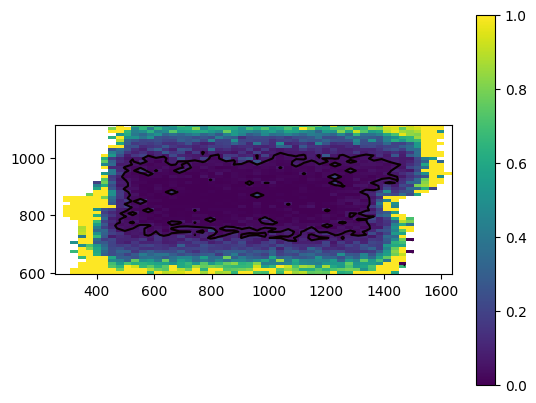

In [117]:
from matplotlib import pyplot as plt

I = C.vertices.groupby(["x_nm_binned_51",
                        "z_nm_binned_51"])["outer_syn_fraction"].max().unstack("x_nm_binned_51")

plt.colorbar(plt.imshow(I.values,
            extent=extents["x_nm"] + extents["z_nm"][::-1]))
plt.contour(I.values, cmap="hot", levels=[0.05],
           extent=extents["x_nm"] + extents["z_nm"])
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])